<img src="../images/cads-logo.png" style="height: 100px;" align=left> 
<img src="../images/sklearn-logo.png" style="height: 100px;" align=right>

# Unsupervised Machine Learning

# Recommender Systems

## Table of Contents

- [Introduction](#Introduction)
    - [What is a recommender engine?](#What-is-a-recommender-engine?)
    - [Paradox of choice](#Paradox-of-choice)
    - [Goals](#Goals)
    - [Types of Interactions](#Types-of-Interactions)
    - [Types of Recommender Systems](#Types-of-Recommender-Systems)
        - [Collaborative Filtering](#Collaborative-Filtering)
        - [Content-Based Filtering](#Content-Based-Filtering)
        - [Other Recommender Systems](#Other-Recommender-Systems)
        - [Summary](#Summary)
    - [Exercises in Creative Thinking](#Exercises-in-Creative-Thinking)
    - ["Simple is Good Enough"](#"Simple-is-Good-Enough")
- [Collaborative Filtering](#Collaborative-Filtering)
    - [Similarity Metrics](#Similarity-Metrics)
        - [Euclidean Distance](#Euclidean-Distance)
        - [Cosine Distance](#Cosine-Distance)
        - [Correlation Distance](#Correlation-Distance)
        - [Summary](#Summary)
    - [Non-personalized Recommendations (Item-item distances)](#Non-personalized-Recommendations-(Item-item-distances))
        - [Compute item-item distances](#Compute-item-item-distances)
        - [Rank items by similarity](#Rank-items-by-similarity)
        - [Compute average ratings](#Compute-average-ratings)
        - [Assessing the prediction](#Assessing-the-prediction)
        - [Exercise](#Exercise)
    - [Personalized Recommendations (User-user distances)](#Personalized-Recommendations-(User-user-distances))
        - [Compute user-user distances](#Compute-user-user-distances)
        - [Rank users by similarity](#Rank-users-by-similarity)
        - [Compute average ratings](#Compute-average-ratings)
        - [Assessing the prediction](#Assessing-the-prediction)
        - [Exercises](#Exercises)
    - [Summary of kNN-approach](#Summary-of-kNN-approach)
    - [Other models](#Other-models)
        - [Baseline](#Baseline)
        - [Regression](#Regression)
        - [Matrix Factorization](#Matrix-Factorization)
        - [Neural Networks](#Neural-Networks)
        - [Comparison of models](#Comparison-of-models)
- [Creating a recommender system in Python using `Surprise`](#Creating-a-recommender-system-in-Python-using-Surprise)
    - [Installing and importing](#Installing-and-importing)
    - [Loading data](#Loading-data)
        - [From a file](#From-a-file)
        - [From a Pandas dataframe](#From-a-Pandas-dataframe)
    - [Setting up the model](#Setting-up-the-model)
    - [Evaluating a model](#Evaluating-a-model)
        - [Evaluation metrics](#Evaluation-metrics)
    - [Optimizing parameters with GridSearchCV](#Optimizing-parameters-with-GridSearchCV)
    - [Applying a model](#Applying-a-model)
    - [Saving the model](#Saving-the-model)
    - [Exercises](#Exercises)
- [Final exercise](#Final-exercise)
- [Summary and final remarks](#Summary-and-final-remarks)


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn.metrics
import scipy.sparse
from IPython.display import display

## Introduction
<br/><center><b>"We are leaving the age of information and entering the age of recommendation"</b><br/>
Chris Anderson "The Long Tail"</center><br/>

We have such a vast amount of data available to us, designing systems to "intelligently" filter this data has become a lucrative business.

- Netflix: 2/3 of watched movies are recommended
- Amazon: 35% of sales come from recommendations
- Google News: recommendations caused 38% more clickthrough 

Recommender systems, also called recommender engines, are a special class of machine learning methods that aim to filter data and, as the name suggests, recommend items to users. 

### What is a recommender engine?
At the highest level, a recommender engine consists of three fundamental steps:
1. USER expresses interest in ITEM
2. Identify items that are similar to ITEM that may also appeal to USER
3. Recommend items to USER, ranked by the similarity to ITEM

### Paradox of choice
- Well-studied phenomenon in human psychology
- States that people not only become unhappier when faced with too many options but have also been shown to be reluctant to act, e.g. buy a product. 
    - In an experiment, a frozen yoghurt shop found that potential customers were more likely to buy a frozen yoghurt if shown fewer choices (Barry Schwartz "The Paradox of Choice - Why Less is More").

### Goals
The primary goal of a recommender system is to **predict how a user would rate an item** they haven't interacted with yet, e.g. predicting movie ratings or recommending products.

In the context of a business, where recommender systems find the widest application, this goal can be broken down into several subgoals:

- **Relevance**
    - Identify items that the user will find most useful or interesting. For example, if a customer buys toothpaste then they are probably also interested in a toothbrush. 
- **Diversity**
    - Recommended items should not be essentially identical. To continue with the example, recommending 10 identical toothbrushes in different colors would most likely annoy a potential customer. 
- **Novelty**
    - Recommender systems should be able to identify novel or rare items. Popular items rarely need to be advertised or recommended and a user will be able to explicitly search for these items. The recommender system should suggest items the user would not have thought of or found by themselves.
- **Serendipity**
    - Closely related to novelty, recommended items should be able to surprise a potential customer. For example, instead of just dental care products, a recommender system could suggest items that benefit oral hygiene indirectly, such as calcium- and fluoride-rich foods.

### Types of Interactions
Interactions form the basis of recommender systems. We differentiate between two kinds of interactions.

- **Explicit interactions**
    - Deliberate actions taken by users, e.g. rating a movie.
    - Usually sparse, e.g. users won't rate hotels they don't stay at
    - Potentially biased towards positive ratings, e.g. users won't watch a movie that has already received overwhelmingly negative reviews.
- **Implicit interactions**
    - By-products of user interaction with a service, e.g. page views of websites or click rates of advertisements
    - Are usually collected automatically, e.g. through web server logs.
    - Much more dense, e.g. a user looking for a hotel for a holiday will browse many different listings. These listings can be analyzed to determine what a user's interests are, e.g. similarities between listings or time spent on each listing page. There may be dozens of listings a user looks at, for which multiple features can be captured. The user will ultimately only leave a single, explicit rating for the hotel he stayed at, however. Furthermore, unless a written review was left as well, this explicit rating will contain only a single, numerical feature.
    - Better representation of user *needs*. For example, a user may rate a 3-hour documentary with 5/5 stars, indicating they love it. Because they are busy, however, they prefer watching TV episodes, even though they may not rate these as highly. Implicit interactions would correctly indicate the preference for short TV shows versus long movies for daily viewing whereas explicit interactions couldn't capture this.

### Types of Recommender Systems
The two fundamental types of recommender systems are *collaborative filtering* and *content-based filtering*. Customized, industry-specific approaches often use additional information to refine these two methods.

#### Collaborative Filtering

Collaborative filtering uses only interaction data between users and items, such as ratings, to make recommendations. The foundation of these approaches is an interaction matrix of the following form:

<table>
    <tr style="border-bottom: 2px solid black;"><th></th><th>User 1</th><th>User 2</th><th>User 3</th><th>User 4</th></tr>
    <tr><th>Item 1</th><td>1</td><td></td><td></td><td>2</td></tr>
    <tr><th>Item 2</th><td>5</td><td>2</td><td></td><td></td></tr>
    <tr><th>Item 3</th><td></td><td>1</td><td>2</td><td></td></tr>
</table>

- This matrix is used to generate a ranked list of recommendations or to infer missing scores. Either items or users are grouped by their similarity with regards to the ratings and recommendations made accordingly.
- The accuracy of recommendations improves both with the total number of user-item interactions as well as the number of users in the dataset themselves.

Collaborative filters are by far the most popular recommender systems. There are two reasons for this:
- **Simple to implement**: No information on the items or users is needed, making these algorithms easy to implement and also transfer to different problems.
- **No feature engineering**: The lack of feature engineering or parameter tweaking means that these systems will usually work 'out of the box' and deliver 'good-enough' results.
  
Disadvantages of collaborative filtering include:
- **Data sparsity**: Especially for explicit ratings, the interaction matrix will be very sparse. For example, a hotel recommendation system may have tens of thousands of hotels in their database. Individual users, however, will only have visited and rated a handful of these. This makes it difficult to compute similarities between hotels.
- **Long training times**: Collaborative filters utilize the entire user-item interaction matrix to make recommendations. This means that any time a new user is added, the item-item distances must be re-calculated. This can lead to a monumental computational overhead for large datasets.
- **Poor performance for small data**: If a dataset has only very few users then a collaborative approach won't exhibit nearly the same power as other approaches.
- **Requires item standardization**: Very similar items in a dataset are still regarded as separate items and must be manually combined beforehand, e.g. if multiple vendors sell the same product through eBay then ratings for the product should be combined and only recommended once.

#### Content-Based Filtering
As opposed to collaborative filtering, which uses the entire ensemble of user-item interactions to make recommendations, content-based filtering focuses on individual users and makes explicit use of item features to create a user-specific content profile. The matrix from above can be extended to include the features of individual items, e.g.

<table>
    <tr style="border-bottom: 2px solid black;"><th></th><th>User 1</th><th>User 2</th><th>User 3</th><th style="border-right: 1px solid black;">User 4</th><th>Item Feature 1</th><th>Item Feature 2</th><th>Item Feature 3</th></tr>
    <tr><th>Item 1</th><td>1</td><td></td><td></td><td style="border-right: 1px solid black;">2</td><td>0.4</td><td>0.8</td><td>0.04</td></tr>
    <tr><th>Item 2</th><td>5</td><td>2</td><td></td><td style="border-right: 1px solid black;"></td><td>0.9</td><td>0.1</td><td>0.3</td></tr>
    <tr><th>Item 3</th><td></td><td>1</td><td>2</td><td style="border-right: 1px solid black;"></td><td>0.85</td><td>0</td><td>0.1</td></tr>
</table>

Predicting user ratings for items essentially becomes a supervised learning problem based on existing ratings.

Advantages of this approach are:
- **Short training times**: Recommendations are made on the basis of ratings given by a single user, which makes updating the recommender system very fast.
- **New items can be immediately recommended**: Whereas collaborative filters would simply ignore items that have never been rated, the inclusion of intrinsic features means that new items in our dataset can be immediately recommended.

It appears content-based filters solve the problems of collaborative filters. However, they also come with their own disadvantages:
- **Cold-start problem**: Because content-based filters do not make use of the entire set of users, new users must first rate many items before personalized recommendations can be made.
- **Feature enginnering**: The nature of the items to be recommended must be quantified in the form of features. Feature engineering for complex data, such as movies, is difficult and can heavily impact the performance of a recommender system.
- **Overspecialization**: The system will never recommend items outside of a user's content profile, which is generated based on historical choices. If a user has never rated a horror movie, for example, the system will never recommend one unless specifically instructed to do so. This is closely related to the cold-start problem.

#### Other Recommender Systems
Recommender systems are often highly specialized and customized to the available data and purpose of the system. For example:

- **Social recommender systems** make use of user demographic data and social connections, e.g. Facebook friendships, to recommend items to users. Aggregating users by their demographics and using connections as metrics of similarity can help alleviate the *cold-start* problem, i.e. making recommendations to a new user without any historical data. This approach still suffers from the "popularity problem" in that popular items will be favored over new and unknown ones.
- **Knowledge-based recommender systems** use explicit user input to make recommendations. For example, a user searching for a property to buy can indicate conditions such as the location, desired number of rooms, the maximum price. This allows personalized recommendations without historical data and is especially useful for situations where historical data is inherently rare, e.g. most people won't buy very many houses in their lives. The downside of this approach is that it requires specific domain knowledge, meaning that the system must know what a user will like without having historical data to validate this, e.g. a user interested in a four-bedroom house most likely has children and will be interested in child-friendly neighborhoods.
- **Hybrid recommender systems** combine collaborative and content-based approaches. This not only improves the recommendation performance but also compensates for the weaknesses of individual recommender systems. Recommenders can be combined as a weighted ensemble, in which recommendations from all systems are collated into a single list, or in a switching manner, where specific recommenders are chosen on a case-by-case basis.

#### Summary

| Approach | Conceptual Goal | Input | 
| -------- | --------------- | ----- |
| Collaborative | Make recommendations based on a collaborative approach that leverages the interactions of the entire user set. | User interactions |
| Content | Create user-specific content profiles based on each individual user's interactions. | User interactions + item attributes | 
| Knowledge | Make recommendations based on explicit content constraints and domain knowledge. | User specification + item attributes + domain knowledge |
| Social | Use similarities and social connections between users to make recommendations | User interactions + demographic data + user connections |
| Hybrid | Combine various recommenders into a more complex engine | Depends on components |

### Exercises in Creative Thinking
There are (almost) no wrong answers!

1. Which types of recommender system is best suited for recommending ... ?
    - Cars
    - Restaurants
    - Products on an E-Shopping site
2. What are some example use cases (don't use the above examples!) that are best handled by ... ?
    - Collaborative filtering
    - Content-based filtering
    - Knowledge-based filtering
3. How can we classify the following types of interactions?
    - Rating a movie
    - Reading a news article
    - Watching a youtube video
    - Writing a restaurant review
    - Searching for vacation accomodations
4. Suppose you are tasked with building a movie recommendation engine. How could you recommend items to new users?

### "Simple is Good Enough"
Even simple recommender systems are quite powerful and very difficult to improve on. As an example, take Netflix's $\$1,000,000$ USD prize for improving on it's first movie recommendation engine, CineMatch. 

- Goal of the competition: improve CineMatch's predictions by at least 10\%. 
- Accuracy metric: root mean square error (RMSE)
- Winning team took two years and achieved a 10.09\% improvement.
    - Winning team: 0.8554
    - CineMatch: 0.9514
    - Average ratings: 1.0540

Simply taking the average of all ratings a movie had already received and "predicting" that average for every user already serves as a reasonably accurate recommender
- e.g. if the average rating for a movie is 4/5 stars, most users would end up rating it with between 3 and 5 stars

<center><b>$\rightarrow$ A simple recommender system is often good enough</b></center>

## Collaborative Filtering
Collaborative filtering is the most popular recommender system, due to its simplicity and power over large datasets. To see how such a recommender system might work, we will look at some dummy data for movie ratings. If a user has not rated a movie yet, we will set the corresponding score to `nan`.

In [2]:
ratings = pd.DataFrame(
    data=[
        [1, 4, 2, 4, 5], 
        [5, np.nan, 4, 1, 3], 
        [1, np.nan, 5, 2, np.nan], 
        [2, 5, np.nan, 2, 4], 
        [np.nan, 2, 4, np.nan, 3], 
        [3, 5, 2, 4, 3]], 
    columns=["The Notebook", "Toy Story", "Bridget Jones' Diary", "Jurassic Park", "Apollo 13"], 
    index=["Joe", "Cindy", "Mark", "Liz", "Mike", "Henry"], 
    dtype=float)
ratings

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,NaN,4.0,1.0,3.0
Mark,1.0,NaN,5.0,2.0,NaN
Liz,2.0,5.0,NaN,2.0,4.0
Mike,NaN,2.0,4.0,NaN,3.0
Henry,3.0,5.0,2.0,4.0,3.0


- No intrinsic item features, e.g. genre or actors
- **User ratings are used as item features**
- Movie details are encoded in user ratings/preference
- **If two movies are given identical ratings by all users then they are similar**

### Similarity Metrics
There are many metrics for computing the similarity, i.e. the distance, between items.

#### Euclidean Distance

The Euclidean distance between two objects with feature vectors $\vec{x}, \vec{y}$ is defined as

$$D(x, y) = \sqrt{\sum (x_i - y_i)^2} = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 +\ldots+ (x_n - y_n)^2}$$

This is the intuitive, geometric distance between two points in feature space. The problem with this metric is it depends on the absolute value of the ratings. Assume the following interaction matrix:

|<i></i>| A | B | C |
| ----- | - | - | - |
| John  | 5 | 3 | 5 |
| Alice | 2 | 1 | 4 |
| Marie | 5 | <i></i> | <i></i> |

Marie has only watched movie A and rated it highly. To recommend another movie to her, we compute the distances between A and B as well as A and C:

In [3]:
d_ab = np.sqrt((5 - 3)**2 + (2 - 1)**2)
d_ac = np.sqrt((5 - 5)**2 + (2 - 4)**2)
print("Euclidean Distance (A , B) = {}".format(d_ab))
print("Euclidean Distance (A , C) = {}".format(d_ac))

Euclidean Distance (A , B) = 2.23606797749979
Euclidean Distance (A , C) = 2.0


According to the Euclidean distance, it seems that movies A and C are more similar to each other than movies A and B. But this isn't actually the case.

If we consider our other two users, we can make the following statements:
- Only John liked movie A
- Only John liked movie B
- Both John and Alice liked movie C

In these qualitative terms, it seems that movies A and B are more similar to each other than movies A and C. The Euclidean distance apparently doesn't capture similarities between rated items properly.

*Notice that when we compute pairwise distances we only include users that have rated both items, i.e. we ignore Marie's rating of movie A because she has rated neither movie B nor C.*

#### Cosine Distance

The reason for this is that similarities between items doesn't depend on the absolute values of ratings but their *relative values*. Let's look at the movie ratings as vectors in *rating space*

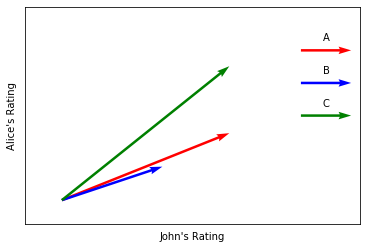

In [4]:
dat = np.array([
    [5, 3, 5], 
    [2, 1, 4]])

fig, ax = plt.subplots();
qv_a = ax.quiver(0, 0, dat[0,0], dat[1,0], color="red", scale=10);
qv_b = ax.quiver(0, 0, dat[0,1], dat[1,1], color="blue", scale=10);
qv_c = ax.quiver(0, 0, dat[0,2], dat[1,2], color="green", scale=10);
plt.xlim(-0.005, 0.04);
plt.ylim(-0.005, 0.04);
ax.set_xticklabels('');
ax.set_yticklabels('');
plt.tick_params(
    axis='both',
    which='both',
    length=0);
plt.quiverkey(qv_a, 0.9, 0.8, 1.5, "A");
plt.quiverkey(qv_b, 0.9, 0.65, 1.5, "B");
plt.quiverkey(qv_c, 0.9, 0.5, 1.5, "C");
plt.xlabel("John's Rating");
plt.ylabel("Alice's Rating");

In rating space, we can very clearly see the qualitative similarity between movies.

- The angle between vectors shows us how similar movies are with regard to user preference
- The length of vectors gives an indication of how good the movies are generally considered to be

We can define the angle between two rating vectors $\vec{x}, \vec{y}$ with the cosine distance:

$$ D(x, y) = 1 - \frac{\sum x_i \cdot y_i}{\sqrt{\sum x_i^2} \cdot \sqrt{\sum y_i^2}} = 1 - \frac{x_1 \cdot y_1 + x_2 \cdot y_2 +\ldots+ x_n \cdot y_n}{\sqrt{x_1^2 + \ldots + x_n^2} \cdot \sqrt{y_1^2 + \ldots + y_n^2}}$$

Characteristics of this distance are:
- the cosine distance can take on values between 0 and 2
- if two vectors point in the same direction, the cosine distance will be 0
- if two vectors point in opposite directions, the cosine distance will be 2

We can immediately see that the cosine distance serves as a metric for the qualitative similarity of rating vectors.

If we look at our dummy data again, we get the following distances:

|<i></i>| A | B | C |
| ----- | - | - | - |
| John  | 5 | 3 | 5 |
| Alice | 2 | 1 | 4 |
| Marie | 5 | <i></i> | <i></i> |

In [5]:
cd_ab = 1 - ((5*3) + (2*1)) / (np.sqrt(5**2 + 2**2) * np.sqrt(3**2 + 1**2))
    
cd_ac = 1 - ((5*3) + (2*4)) / (np.sqrt(5**2 + 2**2) * np.sqrt(5**2 + 4**2))
print("Cosine Distance A <=> B = {}".format(cd_ab))
print("Cosine Distance A <=> C = {}".format(cd_ac))

Cosine Distance A <=> B = 0.0017256268250042117
Cosine Distance A <=> C = 0.3329829908493972


As expected, movies A and B are much more similar with regards to their user ratings than movies A and C. A recommender built on the basis of the cosine distance would correctly recommend movie B to Marie.

#### Correlation Distance
Closely related to the cosine distance is the correlation distance

$$ D(x, y) = 1 - \frac{\sum{(x_i-\bar{x}) \cdot (y_i-\bar{y})}}{\sqrt{\sum(x_i-\bar{x})^2} \cdot \sqrt{\sum(y_i-\bar{y})^2}}$$

where $\bar{x}$ and $\bar{y}$ are the means of the two rating vectors.

The correlation indicates the joint deviation from the mean for each vector. If $x$ and $y$ are:
- Positively correlated, then whenever $x$ increases, so does $y$. 
- Negatively correlated, then whenever $x$ increaes, $y$ decreases and vice versa. 
- Uncorrelated, then they change independently of each other.

What happens if the vectors $x$ and $y$ are centered, i.e. their means are 0? The equation becomes identical to the cosine distance!

<br/><center><b>The correlation distance is the cosine distance between centered versions of two vectors</b></center><br/>

Because it is good practice to normalize features, i.e. ratings, anyway, we will make a point of doing this and using the correlation.

If we look at our mini-example again:

|<i></i>| A | B | C |
| ----- | - | - | - |
| John  | 5 | 3 | 5 |
| Alice | 2 | 1 | 4 |
| Marie | 5 | <i></i> | <i></i> |

then we can obtain the correlation distances as follows:

$$D_{ab} = 1 - \frac{(5 - 3.5) \cdot (3 - 2) + (2 - 3.5) \cdot (1 - 2)}{\sqrt{(5 - 3.5)^2 + (2 - 3.5)^2} \cdot \sqrt{(3 - 2)^2 + (1 - 2)^2}} = 0$$

$$D_{ac} = 1 - \frac{(5 - 3.5) \cdot (5 - 4.5) + (2 - 3.5) \cdot (4 - 4.5)}{\sqrt{(5 - 3.5)^2 + (2 - 3.5)^2} \cdot \sqrt{(4 - 4.5)^2 + (4 - 4.5)^2}} = 0$$

In [6]:
a = np.array((5, 2))
a_cen = a - a.mean()
b = np.array((3, 1))
b_cen = b - b.mean()
c = np.array((5, 4))
c_cen = c - c.mean()

corrd_ab_cen = 1 - (np.sum(a_cen*b_cen) / (np.sqrt(np.sum(a_cen**2)) * np.sqrt(np.sum(b_cen**2))))
corrd_ac_cen = 1 - (np.sum(a_cen*c_cen) / (np.sqrt(np.sum(a_cen**2)) * np.sqrt(np.sum(c_cen**2))))
cosine_ab = 1 - ((a_cen[0]*b_cen[0] + a_cen[1]*b_cen[1] ) / (np.sqrt(a_cen[0]**2 + a_cen[1]**2) * np.sqrt(b_cen[0]**2 + b_cen[1]**2)))
cosine_ac = 1 - ((a_cen[0]*c_cen[0] + a_cen[1]*c_cen[1] ) / (np.sqrt(a_cen[0]**2 + a_cen[1]**2) * np.sqrt(c_cen[0]**2 + c_cen[1]**2)))
print("Cosine Distance A <=> B = {a:.4f}".format(a=cosine_ab))
print("Cosine Distance A <=> C = {a:.4f}".format(a=cosine_ac))
print("Correlation Distance A <=> B = {a:.4f}".format(a=corrd_ab_cen))
print("Correlation Distance A <=> C = {a:.4f}".format(a=corrd_ac_cen))

Cosine Distance A <=> B = 0.0000
Cosine Distance A <=> C = 0.0000
Correlation Distance A <=> B = 0.0000
Correlation Distance A <=> C = 0.0000


We obtain the same qualitative results as for the cosine distance.

#### Summary
Different distance metrics may be better than others for certain types of problems. We can use many different kinds of distance metrics:

- Euclidean
- Cosine
- Correlation
- Manhattan
- Haversine (how far apart are two geographical points, taking the shape of the earth into account?)
- Jaccard (how similar are two sets based on the common elements?)
- etc.

Choosing the correct metric can be tricky and may require a bit of experimentation.

### Non-personalized Recommendations (Item-item distances)
The simplest approach predicting the scores a user would give is a variation of kNN clustering. In essence, we identify the top-k most similar movies, based on the similarities of movie ratings across all users, and average together these ratings for the missing movie:

1. Compute distances between all items
2. Rank items by their similarity to a query ITEM
3. Compute the average rating of the $k$ most similar items to the query ITEM for each user individually.

In [7]:
ratings

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,NaN,4.0,1.0,3.0
Mark,1.0,NaN,5.0,2.0,NaN
Liz,2.0,5.0,NaN,2.0,4.0
Mike,NaN,2.0,4.0,NaN,3.0
Henry,3.0,5.0,2.0,4.0,3.0


#### Compute item-item distances
*Note: Between the cosine and the correlation distances, the correlation distance has a more robust implementation in NumPy/SciPy, which is why we'll be using that. Later, we'll be using a Python library for recommender engines where we will no longer have this limitation and can freely experiment with different distance metrics.*

In [8]:
ratings_distances = 1 - ratings.corr()
ratings_distances

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
The Notebook,0.000000,0.133975,0.941974,1.467707,1.866400
Toy Story,0.133975,0.000000,1.944911,1.500000,0.753817
Bridget Jones' Diary,0.941974,1.944911,0.000000,1.851852,1.577350
Jurassic Park,1.467707,1.500000,1.851852,0.000000,0.593819
Apollo 13,1.866400,0.753817,1.577350,0.593819,0.000000


#### Rank items by similarity
Assume we want to predict the score that Cindy and Mark would give *Toy Story*. First, we identify the top-$k$ most similar movies to *Toy Story*

In [9]:
ratings_distances.loc["Toy Story"].drop("Toy Story").sort_values()

The Notebook            0.133975
Apollo 13               0.753817
Jurassic Park           1.500000
Bridget Jones' Diary    1.944911
Name: Toy Story, dtype: float64

#### Compute average ratings
Lastly, we compute the average of the ratings that each user gave to the top-$k$ most similar movies to *Toy Story*.

Begin by identifying the top-$k$ movies.

In [10]:
# Let k = 2 due to our small dataset
k = 2
top_k_movies = ratings_distances.loc["Toy Story"].drop("Toy Story").sort_values().index[:k]
top_k_movies

Index(['The Notebook', 'Apollo 13'], dtype='object')

Next, compute the average of the ratings for these two movies for each user individually

In [11]:
predicted_ratings = ratings.loc[:, top_k_movies].mean(axis=1)
predicted_ratings

Joe      3.0
Cindy    4.0
Mark     1.0
Liz      3.0
Mike     3.0
Henry    3.0
dtype: float64

Set these scores as the predicted scores for *Toy Story* for Mark and Cindy (we obviously only need to predict missing ratings).

In [12]:
# We don't want to overwrite our ratings data
ratings_copy = ratings.copy()
ratings_copy.loc[["Mark", "Cindy"], "Toy Story"] = predicted_ratings.loc[["Mark", "Cindy"]]
ratings_copy

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,4.0,4.0,1.0,3.0
Mark,1.0,1.0,5.0,2.0,NaN
Liz,2.0,5.0,NaN,2.0,4.0
Mike,NaN,2.0,4.0,NaN,3.0
Henry,3.0,5.0,2.0,4.0,3.0


#### Assessing the prediction
We can compare the existing ratings and the predicted ratings to assess how accurate this prediction is. Ideally, our prediction should exactly match existing ratings. An easy error metric here is the root mean square error (RMSE), i.e. the numerical deviation of the predictions from the actual ratings.

In [13]:
np.sqrt(np.mean((predicted_ratings - ratings.loc[:, "Toy Story"])**2))

1.5811388300841898

#### Exercise
Predict the scores for all other missing ratings.

*Bonus: as an exercise in good practice, try to make your code as reusable as possible. For example, write a function that takes a rating matrix, identifies which movie-user pairs are missing, and predicts scores according as shown with the movie Toy Story above*

In [14]:
### Complete the code
def predict_scores_itemitem(ratings_matrix, k=2):
    # Create a copy of the object as we don't want to change the actual ratings!
    ratings_matrix = ratings_matrix.copy()
    
    # Compute item-item distances
    d = 1-ratings_matrix.corr()

    # Loop through movies to identify missing ratings
    for movie in ratings_matrix.columns:
        
        # Identify missing ratings
        missing_users = ratings_matrix.loc[:, movie].isna()

        # Identify top-k movies
        top_k_movies = d.loc[movie].drop(movie).sort_values().index[:k]

        # Compute average values of top-k movies
        predicted_ratings = ratings.loc[missing_users, top_k_movies].mean(axis=1)

        # Set the predicted rating
        ratings_matrix.loc[missing_users, movie] = predicted_ratings
    
    return ratings_matrix

predict_scores_itemitem(ratings,2)

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,4.0,4.0,1.0,3.0
Mark,1.0,1.0,5.0,2.0,2.0
Liz,2.0,5.0,3.0,2.0,4.0
Mike,3.0,2.0,4.0,3.0,3.0
Henry,3.0,5.0,2.0,4.0,3.0


In [15]:
# MC
def predict_scores_itemitem(ratings_matrix, k=2):
    # Create a copy of the object as we don't want to change the actual ratings!
    ratings_matrix = ratings_matrix.copy()
    
    # Compute item-item distances
    d = 1 - ratings_matrix.corr()

    # Loop through movies to identify missing ratings
    for movie in ratings_matrix.columns:
        
        # Identify missing ratings
        missing_users = ratings_matrix.loc[:, movie].isna()

        # Identify top-k movies
        top_k_movies = d.loc[movie].drop(movie).sort_values().index[:k]

        # Compute average values of top-k movies
        predicted_ratings = ratings.loc[missing_users, top_k_movies].mean(axis=1)

        # Set the predicted rating
        ratings_matrix.loc[missing_users, movie] = predicted_ratings
    
    return ratings_matrix

predict_scores_itemitem(ratings)

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,4.0,4.0,1.0,3.0
Mark,1.0,1.0,5.0,2.0,2.0
Liz,2.0,5.0,3.0,2.0,4.0
Mike,3.0,2.0,4.0,3.0,3.0
Henry,3.0,5.0,2.0,4.0,3.0


### Personalized Recommendations (User-User Distances)
Computing item distances based on the entire user set may not be accurate. If someone's taste in movies is fundamentally different from my own, then they should have no input in determining how similar two movies are in my opinion. Wouldn't it be better, therefore, to predict movie ratings based on what users with similar tastes in movies thought?

A more intuitive approach to predicting how a query USER would rate a query ITEM is be summarized in the following steps:

1. Compute distances between all users
2. Identify top-$k$ similar users to a query USER
3. Compute (weighted) average rating for ITEM as given by similar users 

In [16]:
ratings

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,NaN,4.0,1.0,3.0
Mark,1.0,NaN,5.0,2.0,NaN
Liz,2.0,5.0,NaN,2.0,4.0
Mike,NaN,2.0,4.0,NaN,3.0
Henry,3.0,5.0,2.0,4.0,3.0


#### Compute user-user distances

In [17]:
ratings_distances = 1 - ratings.transpose().corr()
ratings_distances

,Joe,Cindy,Mark,Liz,Mike,Henry
Joe,0.000000,1.748331,0.947586,0.422650,1.654654,0.519616
Cindy,1.748331,0.000000,0.961538,1.000000,0.000000,1.717137
Mark,0.947586,0.961538,0.000000,NaN,NaN,1.720577
Liz,0.422650,1.000000,NaN,0.000000,2.000000,0.477767
Mike,1.654654,0.000000,NaN,2.000000,0.000000,1.981981
Henry,0.519616,1.717137,1.720577,0.477767,1.981981,0.000000


#### Rank users by similarity
Assume we want to predict the score that Liz would give *Bridget Jones' Diary*. First, we rank users by similarity to Liz.

In [18]:
ratings_distances.loc["Liz"].drop("Liz").sort_values()

Joe      0.422650
Henry    0.477767
Cindy    1.000000
Mike     2.000000
Mark          NaN
Name: Liz, dtype: float64

#### Compute average ratings
Now, we compute the average of the ratings that the most similar users to Liz gave *Bridget Jones' Diary*.

Begin by identifying the top-$k$ similar users.

In [19]:
# Let k = 2 due to our small dataset
k = 2
top_k_users = ratings_distances.loc["Liz"].drop("Liz").sort_values().index[:k]
top_k_users

Index(['Joe', 'Henry'], dtype='object')

Next, compute the average rating these two users gave to each movie.

In [20]:
predicted_ratings = ratings.loc[top_k_users].mean(axis=0)
predicted_ratings

The Notebook            2.0
Toy Story               4.5
Bridget Jones' Diary    2.0
Jurassic Park           4.0
Apollo 13               4.0
dtype: float64

Set the rating for *Bridget Jones' Diary* as the predicted score for Liz.

In [21]:
# We don't want to overwrite our ratings data
ratings_copy = ratings.copy()
ratings_copy.loc["Liz", "Bridget Jones' Diary"] = predicted_ratings.loc["Bridget Jones' Diary"]
ratings_copy

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,NaN,4.0,1.0,3.0
Mark,1.0,NaN,5.0,2.0,NaN
Liz,2.0,5.0,2.0,2.0,4.0
Mike,NaN,2.0,4.0,NaN,3.0
Henry,3.0,5.0,2.0,4.0,3.0


#### Assessing the prediction
Like before, we can assess this prediction.

In [22]:
np.sqrt(np.mean((predicted_ratings - ratings.loc["Liz"])**2))

1.0307764064044151

*Note: We would have to compute the RMSE for the entire interaction matrix to properly assess which of these two methods are better!*

#### Exercises
1. Predict the scores for all missing ratings, but this time using the user-user distance.

  *Bonus: as an exercise in good practice, try to make your code as reusable as possible. For example, write a function that takes a rating matrix, identifies which movie-user pairs are missing, and predicts scores according as shown with the example shown in this section*

In [23]:
### Your code here
# def predict_scores(ratings_matrix, k=2):
#     ...

In [24]:
# MC
def predict_scores_useruser(ratings_matrix, k=2):
    # Create a copy of the object as we don't want to change the actual ratings!
    ratings_matrix = ratings_matrix.copy()
    
    # Compute user-user distances
    d = 1 - ratings_matrix.transpose().corr()

    # Loop through users to identify missing ratings
    for user in ratings_matrix.index:
        
        # Identify missing ratings
        missing_movies = ratings_matrix.loc[user,:].isna()

        # Identify top-k users
        top_k_users = d.loc[user].drop(user).sort_values().index[:k]

        # Compute average ratings of top-k users for all movies
        predicted_ratings = ratings.loc[top_k_users, missing_movies].mean(axis=0)

        # Set the predicted rating
        ratings_matrix.loc[user, missing_movies] = predicted_ratings
    
    return ratings_matrix

predict_scores_useruser(ratings)

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,1.0,4.0,2.0,4.0,5.0
Cindy,5.0,2.0,4.0,1.0,3.0
Mark,1.0,4.0,5.0,2.0,4.0
Liz,2.0,5.0,2.0,2.0,4.0
Mike,3.0,2.0,4.0,2.5,3.0
Henry,3.0,5.0,2.0,4.0,3.0


2. Compare the predicted ratings of these two methods. Are there any major discrepancies?

In [25]:
### Your code here

In [26]:
# MC
predicted_scores_ii = predict_scores_itemitem(ratings)
predicted_scores_uu = predict_scores_useruser(ratings)
diff = np.abs(predicted_scores_ii - predicted_scores_uu)
diff

,The Notebook,Toy Story,Bridget Jones' Diary,Jurassic Park,Apollo 13
Joe,0.0,0.0,0.0,0.0,0.0
Cindy,0.0,2.0,0.0,0.0,0.0
Mark,0.0,3.0,0.0,0.0,2.0
Liz,0.0,0.0,1.0,0.0,0.0
Mike,0.0,0.0,0.0,0.5,0.0
Henry,0.0,0.0,0.0,0.0,0.0


### Summary of kNN-approach

- **Item-item distances**: Users who liked MOVIE also liked the following movies ...
    - Doesn't take different user preferences into account; item similarities depend strongly on which users are actually in our database.
    - Predictions suffer from coincidental overlaps, e.g. most people like *Game of Thrones* and *Armageddon* but that's not an indication that these two movies are similar.
- **User-user distances**: Users with your taste in movies also liked the following movies ...
    - Predictions are more intuitively justifiable
    - Doesn't identify rare movies: if none of the top-$k$ similar users have never watched MOVIE, then no rating can be predicted and the movie can't be recommended
    
Which of these two works better depends on the sparsity of the interaction matrix and the relative numbers of items and users. For example, datasets with a small number of items may not accurately capture similarities between users.

### Other models
The kNN-based approach is one model that we can use to predict scores. The downside of this approach is that it is computationally expensive. Computing the distance matrix for thousands of items can quickly become unfeasible. For example, if we assume that Netflix has 10,000 movies in its database, then the distance matrix would require nearly 50 million entries.

#### Baseline
As previously mentioned, simple recommenders are often "good enough". The principle behind the baseline approach is that a user's $u$ predicted rating for a movie $i$ is

$$ \hat r_{ui} = \mu + b_u + b_i$$

- $\mu$: This is simply the global average of all known ratings
- $b_u$ and $b_i$: These are user- and item biases.

The idea behind a bias is that they express how a user typically rates movies and how well movies are typically rated.

For example, if John is a very critical person, his user bias would be negative. On the other hand, *Titanic* was a wildly successful movie and rated highly by most people so it will have a positive bias associated with it.

The biases are determined by optimizing the above equation for all known ratings, i.e. minimizing

$$ min_{b_i, b_u} \sum_{ui} (r_{ui} - \mu - b_u - b_i)^2 + \lambda \left(\sum_u b_u^2 + \sum_i b_i^2\right)$$

(Note the regularization term!)

#### Regression
We can, in principle, replace kNN with any other regression model, such as linear regression.

A surprisingly powerful linear regression variant is the *Slope One* algorithm, which enforces a slope of one, i.e. $f(x) = x + b$. It is particularly attractive due to its speed and the fact that it is completely parameter free.
In this model:
$$ \hat r_{ui} = \mu_u + \frac{1}{|R_i(u)|} \sum_{j \in R_i(u)} {dev(i,j)}$$

where $𝑅_i(𝑢)$ is the set of relevant items, i.e. the set of items 𝑗 rated by 𝑢 that also have at least one common user with 𝑖. Also, dev(𝑖,𝑗) is defined as the average difference between the ratings of 𝑖 and those of 𝑗:

$$ dev(i,j) = \frac{1}{U_{ij}} \sum_{u \in U_{ij}} {r_{ui}-r_{uj}}$$

#### Matrix Factorization
A powerful and common alternative is called *matrix factorization*. The fundamental principle behind matrix factorization is that an interaction matrix can be represented as the product of two matrices, the user and item matrix.

![Matrix Factorization](../images/matrix-factorisation.png)

These matrices identify relationships between users, e.g. similar tastes in movies, and items and condense the sparse information into so-called *latent features*. These latent features could, for example, encode the "amount" of action or comedy in a movie and user preferences for these genres.


![Matrix Factorization](../images/matrix-factorisation.jpg)


<center><i>The user matrix, left, encodes each users preference for movie genres and the item matrix, top, encodes the content of each movie. The final rating is then simply the vector product of the latent user and item features ($\sum u_{comedy} \cdot i_{comedy} + u_{action} \cdot i_{action}$)</i></center>

It's important to note that we have no direct control over what these features actually encode; they're determined entirely by the existing data and relationships between users and items.

The huge advantage of this approach over kNN is that we can learn this factorization via gradient descent or other iterative methods and don't ever need to compute the entire similarity matrix.

For a thorough introduction to the motivation behind matrix factorization, see the following [Youtube video](https://www.youtube.com/watch?v=ZspR5PZemcs)

#### Neural Networks
More complex models on the basis of neural networks, such as *Restricted Boltzman Machines (RBM)* also exist. Several of the leading models of the Netflix prize made use of RBMs. Due to their complexity and the small improvement in prediction accuracy, however, they should be a "last resort".

#### Comparison of models
The following metrics show how individual models perform on the Movielens 1M dataset. This dataset consists of 1M movie ratings given by 6000 users on 4000 movies. We can see how matrix factorization methods not only improve on kNN but, with the exception of SVD++, reduce notably computation time.

It's also worth pointing out that the baseline approach, i.e. using only user- and item averages to make predictions, appears to be better than a number of models. Selecting the correct model is often a matter of trial-and-error.

| Movielens 1M | RMSE | Time | Type | 
| - | - | - | - |
| SVD | 0.873 | 0:02:13 | Matrix factorization |
| SVD++ | 0.862 | 2:54:19 | Matrix factorization |
| NMF | 0.916 | 0:02:31 | Matrix factorization |
| Slope One | 0.907 | 0:02:31 | A simple linear regression model |
| k-NN | 0.923 | 0:05:27 | Nearest neighbors |
| Centered k-NN | 0.929 | 0:05:43 | Nearest neighbors |
| k-NN Baseline | 0.895 | 0:05:55 | Nearest neighbors |
| Co-Clustering | 0.915 | 0:00:31 | Alternative clustering model |
| Baseline | 0.909 | 0:00:19 | Simple prediction based only on user- and item averages |
| Random | 1.504 | 0:00:19 | Predict (normally distributed) random values based on the distribution of known ratings |

## Creating a recommender system in Python using `Surprise`
Luckily, we don't have to implement every model by hand, there are libraries that make our lives easier. The easiest one to use is `Surprise`.

`Surprise` attempts to mirror the `scikit-learn` API so much of this code will appear familiar!

### Installing and importing

In [22]:
#pip install scikit-surprise

In [2]:
import surprise

### Loading data
`Surprise` allows any custom dataset to be loaded. Data must be stored as a table, either as file or a Pandas dataframe, with either 3 or 4 columns: user, item, rating, and (optionally) timestamp, e.g. 

| user | item | rating | timestamp | 
| ---- | ---- | ------ | --------- |
| $\ldots$ | $\ldots$ | $\ldots$ | $\ldots$ |

The columns can be in any order, as long as at least the user and item ID/Name as well as the rating are present. Note that the timestamp column is effectively ignored.

#### From a file

In [29]:
# !head ../Data/movielens/ratings.csv

A `Reader` object parses a file (or a dataframe). 
- The `line_format` parameter indicates which order the columns are in. Note that these are space-separated keywords, not actual column names. If a file were in the format `Time, Movie Rating, User Name, Movie Title` then the `line_format` parameter would take on the value "timestamp rating user item".
- The `sep` parameter defines the separating character, e.g. a comma for CSV files.
- The `skip_lines` parameter defines how many lines to skip and not attempt to parse, e.g. header lines or comments.
- The `rating_scale` parameter defines the range of ratings. This is 1 to 5 by default.

In [3]:
from surprise import Reader
from surprise import Dataset

reader = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5))
data = Dataset.load_from_file(file_path="../Data/movielens/ratings.csv", reader=reader)
data

#### From a Pandas dataframe
Reading from a dataframe is a bit inflexible in that it absolutely requires the dataframe to have only three columns: item rating, item ID, user ID (again, in any order).

In [5]:
import pandas as pd
pd_df = pd.read_csv("../Data/movielens/ratings.csv", sep=',')
pd_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
reader = Reader(line_format="user item rating")
data = Dataset.load_from_df(df=pd_df.iloc[:, 0:3], reader=reader)
data

### Setting up the model
Setting up a model can be done in a single line

In [33]:
# model = surprise.KNNBasic()
# model = surprise.SVD()
# model = surprise.SlopeOne()
# model = surprise.KNNWithZScore()
# ...

Each model has individual parameters that we can tune. For example, the nearest neighbor variants have 3 primary parameters:
- k: the maximum number of neighbors to consider
- min_k: the minimum number of neighbors to consider (neighbors are sometimes disqualified due to extreme dissimiarities)
- sim_options: Tweaks the distance metric. This is a dictionary of key-value pairs, e.g.
    - `{"name": "cosine", "user_based": True}`: User-user cosine distance
    - `{"name": "pearson", "user_based": False}`: Item-item correlation distance
    - See the documentation for more details on [similarity metric configuration](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration) and the [available similarity measures](https://surprise.readthedocs.io/en/stable/similarities.html#module-surprise.similarities)
    
An overview of all implemented models and their corresponding parameters can be found in the [documentation](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)

### Build and Evaluate a Model
The most robust method of evaluating model performance is cross validation. `Surprise` makes it very simple to do just that.

#### Evaluation metrics
`Surprise` supports three evaluation metrics
- Root mean squared error (RMSE):
    - $\sqrt{\sum{(r_{predicted} - r_{real})^2}~/~N}$
    - Penalizes large differences
- Mean absolute error (MAE)
    - $\sum{\lvert r_{predicted} - r_{real} \rvert}~/~N$
    - This is a variation of the RMSE that looks at the absolute difference rather than the squared difference between true and predicted rating.
    - This metric doesn't penalize large differences as much as the RMSE.
- Fraction of concordant pairs (FCP)
    - If we're not interested in the numerical deviation of the rating but the difference in ranking then we can use the FCP.
    - A pair of movies $i, j$ is considered *concordant* if the sign of the difference of real ratings, $sgn(r_i - r_j)$, is the same as the sign of the difference of the predicted ratings, $sgn(\hat{r}_i - \hat{r}_j)$. The pair is considered discordant if this is not the case. The FCP measures the fraction of concordant pairs.
    
Choosing a performance metric to optimize for depends on the goal of the recommender.
- When is predicting the numerical rating important?
- When is only a ranking important?
- How is it beneficial to punish outliers?

In [7]:
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import train_test_split


# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

# We'll use the famous SVD algorithm.
algo = KNNBasic()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute accuracy metrics
accuracy.rmse(predictions)
accuracy.mae(predictions)
accuracy.fcp(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9562
MAE:  0.7333
FCP:  0.6754


0.6753957057478249

### Cross Validation

In [8]:
from surprise.model_selection import cross_validate

model = KNNBasic(sim_options={"name": "cosine", "user_based": True})
result = cross_validate(model, data, measures=['RMSE', 'MAE', 'FCP'], cv=3, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, FCP of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9791  0.9797  0.9813  0.9800  0.0009  
MAE (testset)     0.7546  0.7549  0.7576  0.7557  0.0013  
FCP (testset)     0.6695  0.6673  0.6716  0.6695  0.0018  
Fit time          0.34    0.35    0.35    0.35    0.00    
Test time         1.85    1.72    1.67    1.75    0.07    


In [9]:
result

{'test_rmse': array([0.97908516, 0.97969896, 0.98126018]),
 'test_mae': array([0.75462511, 0.75491678, 0.7575652 ]),
 'test_fcp': array([0.66948438, 0.66730592, 0.67160176]),
 'fit_time': (0.3441145420074463, 0.3458845615386963, 0.34671664237976074),
 'test_time': (1.8509092330932617, 1.7236790657043457, 1.67307448387146)}

### Optimizing parameters with GridSearchCV
As with other machine learning models, we can use a grid search to fine-tune parameters. `Surprise` imitates the `scikit-learn` API for this and makes it easy for us.

In [10]:
from surprise.model_selection import GridSearchCV 

search = GridSearchCV(algo_class=KNNBasic,
                    param_grid={"sim_options": {"name": ["cosine"], 
                                "user_based": [True, False]}}, 
                    measures=["RMSE", "MAE", "FCP"], cv=3, n_jobs=-2)
search.fit(data)

In [11]:
search.cv_results

{'split0_test_rmse': array([0.97721412, 0.97260668]),
 'split1_test_rmse': array([0.97592148, 0.97762892]),
 'split2_test_rmse': array([0.98772497, 0.98147495]),
 'mean_test_rmse': array([0.98028686, 0.97723685]),
 'std_test_rmse': array([0.00528595, 0.00363106]),
 'rank_test_rmse': array([2, 1], dtype=int64),
 'split0_test_mae': array([0.75371056, 0.75703758]),
 'split1_test_mae': array([0.75197063, 0.76122237]),
 'split2_test_mae': array([0.76125691, 0.76408834]),
 'mean_test_mae': array([0.75564604, 0.76078276]),
 'std_test_mae': array([0.00403057, 0.0028952 ]),
 'rank_test_mae': array([1, 2], dtype=int64),
 'split0_test_fcp': array([0.67429918, 0.43350812]),
 'split1_test_fcp': array([0.66578967, 0.43558794]),
 'split2_test_fcp': array([0.66801449, 0.43789679]),
 'mean_test_fcp': array([0.66936778, 0.43566428]),
 'std_test_fcp': array([0.00360338, 0.00179248]),
 'rank_test_fcp': array([2, 1], dtype=int64),
 'mean_fit_time': array([ 0.59953443, 13.21617619]),
 'std_fit_time': array(

In [12]:
search.best_params

{'rmse': {'sim_options': {'name': 'cosine', 'user_based': False}},
 'mae': {'sim_options': {'name': 'cosine', 'user_based': True}},
 'fcp': {'sim_options': {'name': 'cosine', 'user_based': True}}}

In [13]:
best_model = search.best_estimator
best_model

{'rmse': <surprise.prediction_algorithms.knns.KNNBasic at 0x1ef0fa7cf10>,
 'mae': <surprise.prediction_algorithms.knns.KNNBasic at 0x1ef0fa7cee0>,
 'fcp': <surprise.prediction_algorithms.knns.KNNBasic at 0x1ef04866c40>}

### Applying the Best Model from GridSearch Result
Once we've decided on a model identified the best parameters for it, we can begin to use it. 

In [14]:
# Create and fit the model
model = search.best_estimator['fcp']
model.fit(trainset)
predictions = model.test(testset)
accuracy.fcp(predictions)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
FCP:  0.6729
RMSE: 0.9796
MAE:  0.7553


0.7552965215548068

In [15]:
predictions[0:3]

[Prediction(uid=50, iid=4282, r_ui=3.5, est=3.502175149086966, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=603, iid=2993, r_ui=3.0, est=3.525592547014741, details={'actual_k': 14, 'was_impossible': False}),
 Prediction(uid=140, iid=11, r_ui=4.0, est=3.849467727098936, details={'actual_k': 40, 'was_impossible': False})]

In [16]:
single_prediction = model.predict(uid=10, iid=10)
single_prediction

Prediction(uid=10, iid=10, r_ui=None, est=3.59946358634476, details={'actual_k': 40, 'was_impossible': False})

In [17]:
print(single_prediction[0]) # User ID
print(single_prediction[1]) # Item ID
print(single_prediction[2]) # Real Rating (This will always be None 
                            # if not explicitly passed to the predict() 
                            # function. The test() function identifies
                            # the real rating correctly, though)
print(single_prediction[3]) # Predicted Rating
print(single_prediction[4]) # Additional details about the model

10
10
None
3.59946358634476
{'actual_k': 40, 'was_impossible': False}


### Save the Model
We can, of course, save a model to disk once it is trained. We can save the model, the predictions, or both in the same file.

In [18]:
from surprise.dump import dump

dump(file_name="movie_recommendations.pkl", predictions=predictions, algo=model)
dump(file_name="movie_recommendations_only-model.pkl", algo=model)
dump(file_name="movie_recommendations_only-predictions.pkl", predictions=predictions)

Loading is just as easy. The function will always load a tuple `(predictions, model)`, even if one of the values is `None` because it wasn't saved.

In [19]:
from surprise.dump import load

predictions, model = load(file_name="movie_recommendations.pkl")
print(type(predictions))
print(type(model))

<class 'list'>
<class 'surprise.prediction_algorithms.knns.KNNBasic'>


In [20]:
predictions, model = load(file_name="movie_recommendations_only-model.pkl")
print(type(predictions))
print(type(model))

<class 'NoneType'>
<class 'surprise.prediction_algorithms.knns.KNNBasic'>


In [21]:
predictions, model = load(file_name="movie_recommendations_only-predictions.pkl")
print(type(predictions))
print(type(model))

<class 'list'>
<class 'NoneType'>


**Exercise:**

The SVD algorithm was popularized as an efficient matrix factorization algorithm in the scope of the Netflix prize. The three most important parameters that can be tweaked here are the number of latent factors, the regularization, and whether to include user and item biases.
    - Use a grid search to identify the best combination of these parameter values
        - `n_factors: [20, 100]`
        - `reg_all: [0, 0.02, 0.2]`
        - `biased: [True, False]` 
    - Train the best model on trainset (the same trainset we used for kNN)
    - Predict ratings on testset (the same trainset we used for kNN)
    - Compare the kNN predictions from above with these SVD predictions

In [49]:
knn_predictions = predictions

### Your code here

In [50]:
# MC
from surprise import SVD

# Run grid search on SVD parameters
search = GridSearchCV(algo_class=SVD, 
                      param_grid={"n_factors": [20, 10]}, 
                       measures=["FCP"], cv=3, n_jobs=-2)
search.fit(data)

In [51]:
# MC
# Identify the best parameters
search.best_params

{'fcp': {'n_factors': 10}}

In [52]:
# MC
# Train on the entire dataset

model = search.best_estimator["fcp"]
model.fit(trainset)

In [53]:
# MC
# Apply to unknown ratings
svd_predictions = model.test(testset)

In [54]:
accuracy.fcp(svd_predictions)
accuracy.rmse(svd_predictions)
accuracy.mae(svd_predictions)

FCP:  0.6663
RMSE: 0.8774
MAE:  0.6748


0.6748045142217277

In [55]:
accuracy.fcp(knn_predictions)
accuracy.rmse(knn_predictions)
accuracy.mae(knn_predictions)

FCP:  0.6729
RMSE: 0.9796
MAE:  0.7553


0.7552965215548068

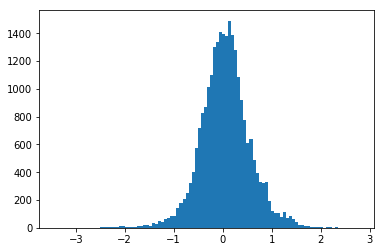

In [56]:
# MC
# Compare kNN and SVD results
knn_ratings = np.array([entry[3] for entry in knn_predictions])
svd_ratings = np.array([entry[3] for entry in svd_predictions])

plt.hist(knn_ratings - svd_ratings, bins=100);

In [57]:
# MC
# More comparisons
print("SVD: {:.4f} +/- {:.4f}".format(np.mean(svd_ratings), np.std(svd_ratings)))
print("kNN: {:.4f} +/- {:.4f}".format(np.mean(knn_ratings), np.std(knn_ratings)))

SVD: 3.5016 +/- 0.5693
kNN: 3.5509 +/- 0.5703


**Exercise:**

A second dataset we'll be looking at is the Jester joke rating database. In this dataset, 139 jokes were rated on a scale from -10 (not funny) to 10 (funny). In the full dataset, nearly 75k users rated these jokes but we'll only use a random subset of 5k users to reduce the computation time.

[Jester data source](https://grouplens.org/datasets/jester/).

1. The file `ratings.csv` is a comma-separated file containing the joke ratings. Load the file into a Pandas dataframe to explore it.

In [58]:
### Your code here

In [59]:
# MC
jokes = pd.read_csv("../Data/jester/ratings_small.csv")
jokes.head()

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [60]:
jokes.shape

(50000, 4)

The file `joke_text.csv` contains the actual jokes for your convenience.

2. Explore the data. 
    - How many jokes are rated?
    - How many user rated jokes?
    - How many jokes rated by each user? Print the result for the first ten users.
    - Find the jokes with the highest and lowest mean scores.

In [61]:
# MC
# How many jokes are rated?

print("How many jokes are rated? ", len(jokes.groupby("joke_id")))

# How many user rated jokes?

print("How many user rated jokes? ", len(jokes.groupby("user_id")))

# How many jokes rated by each user?

print("How many jokes rated by each user? ")
jokes.groupby("user_id")['joke_id'].count()[:10]

How many jokes are rated?  139
How many user rated jokes?  24175
How many jokes rated by each user? 


user_id
1     4
4     6
6     1
7     5
8     1
9     2
10    1
12    2
14    6
17    1
Name: joke_id, dtype: int64

In [62]:
# MC
mean_ratings = jokes.groupby("joke_id")["Rating"].mean().sort_values(ascending=False)
best_joke = mean_ratings.index[0]
print('best_joke ID: ',best_joke)
worst_joke = mean_ratings.index[-1]
print('worst_joke ID: ',worst_joke)

best_joke ID:  17
worst_joke ID:  33


In [63]:
joke_text = pd.read_csv("../Data/jester/jokes.csv")

In [64]:
joke_text.head()

,joke_id,joke_text
0,1,Q. What's O. J. Simpson's web address? A. Slas...
1,2,How many feminists does it take to screw in a ...
2,3,Q. Did you hear about the dyslexic devil worsh...
3,4,They asked the Japanese visitor if they have e...
4,5,Q: What did the blind person say when given so...


In [65]:
# MC
# Load joke texts
best_joke_text = joke_text.loc[joke_text["joke_id"] == best_joke, "joke_text"]
print('\n****************** Best Joke *******************\n')
print(best_joke_text.values[0])
print('\n****************** Worst Joke *******************\n')
worst_joke_text = joke_text.loc[joke_text["joke_id"] == worst_joke, "joke_text"]
print(worst_joke_text.values[0])


****************** Best Joke *******************

Bill Clinton returns from a vacation in Arkansas and walks down the steps of Air Force One with two pigs under his arms. At the bottom of the steps, he says to the honor guardsman, "These are genuine Arkansas Razor-Back Hogs. I got this one for Chelsea and this one for Hillary." The guardsman replies, "Nice trade, Sir."

****************** Worst Joke *******************

Arnold Schwarzenegger and Sylvester Stallone are making a movie about the lives of the great composers. Stallone says, "I want to be Mozart." Swartzeneger says, "In that case...I'll be Bach."


3. Since jokes is still large, select a subset of jokes where user_id < 1000 and joke_id < 100, and save it as joke2. Load joke2 ratings into the `Surprise` format. You can either load it from the file or from the Pandas dataframe. Be sure to use the correct line format for the `Reader` object!

In [66]:
### Your code here
jokes.head()

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [67]:
# MC
jokes2 = jokes.loc[(jokes.user_id < 1000) & (jokes.joke_id < 100) ,:]
print(jokes2.shape)
jokes2.head()

(1083, 4)


,id,user_id,joke_id,Rating
26,18_6,18,6,-8.250
47,85_17,85,17,9.406
250,482_77,482,77,4.938
318,179_98,179,98,2.844
371,910_82,910,82,9.500


In [68]:
# MC
reader = Reader(line_format="user item rating", 
                skip_lines=1, sep=",", rating_scale=(-10, 10))
data = Dataset.load_from_df(jokes2.iloc[:,1:4], reader=reader)
data

4. Selecting the optimal model can be a time-consuming process. For the sake of this exercise, we want to compare only a few: `KNNBasic`, `SVD`, `SlopeOne`, and `BaselineOnly`.
    - Perform a GridSearchCV for `KNNBasic` with the parameter grid
        - `sim_options: {"name": ["cosine", "pearson"], "user_based": [True]}`
    - Perform a GridSearchCV for `SVD` with the parameter grid
        - `biased: [True, False]`
    - Perform a simple cross validation evaluation for `SlopeOne` and `BaselineOnly`. These do not have any parameters that we can or want to tweak so we do not need any grid search.
    - Compare the cross validation results of these four models to identify the best one for this dataset.

  Use only the RMSE metric.
  
  *This may take some time to compute. To speed up computation, set `cv=3` to reduce the number of iterations required.*

In [69]:
### Your code here

In [70]:
# MC
knn_search = GridSearchCV( algo_class=KNNBasic,
                           param_grid={"sim_options": {"name": ["cosine", "pearson"], 
                                                       "user_based": [True]}}, 
                           measures=["RMSE"], cv=3, n_jobs=-2)
knn_search.fit(data)

In [71]:
# MC
svd_search = GridSearchCV(algo_class=SVD, 
                          param_grid={"biased": [True, False]}, 
                          measures=["RMSE"], cv=3, n_jobs=-2)
svd_search.fit(data)

In [72]:
# MC
so_cv = cross_validate(surprise.SlopeOne(), data, measures=['RMSE'], 
                       cv=3, n_jobs=-2, verbose=False)

bo_cv = cross_validate(surprise.BaselineOnly(), data, measures=['RMSE'], 
                       n_jobs=-2, cv=3, verbose=False)

In [73]:
# MC
print("KNNBasic mean RMSE (best parameters): {}".format(knn_search.best_score["rmse"]))
print("SVD mean RMSE (best parameters): {}".format(svd_search.best_score["rmse"]))
print("SlopeOne mean RMSE: {}".format(so_cv["test_rmse"].mean()))
print("BaselineOnly mean RMSE: {}".format(bo_cv["test_rmse"].mean()))

KNNBasic mean RMSE (best parameters): 5.70977280706319
SVD mean RMSE (best parameters): 5.413643646335118
SlopeOne mean RMSE: 6.334183233919645
BaselineOnly mean RMSE: 5.438057556358072


In [74]:
# MC
# Best SVD model parameters
svd_search.best_params

{'rmse': {'biased': True}}

3. Train the best model on the entire set of known ratings and then predict the unknown ratings.


**Hint:**

We can first train the model on the entire dataset of known ratings and then predict the ratings for all unknown user-item ratings.

- `trainset = data.build_full_trainset()`: It de-folds the dataset and gives us the full data as trainset

- `testset = trainset.build_testset()`: It extracts all known ratings and returns them as a list of tuples. This is equivalent to the trainset

- `testset = trainset.build_anti_testset()`: It extracts all combinations of users and items that have no known rating and creates a list of tuples of these. Take note that this can be an extremely large dataset!

In [75]:
### Your code here
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [76]:
# MC
# Train on the entire dataset
model = svd_search.best_estimator["rmse"]
model.fit(trainset)

# Apply to the unknown ratings
predictions = model.test(testset)

## Summary and final remarks
We've covered a fraction of recommender systems with this class, but hopefully enough to give you a starting point for your continued education. Some important notes in summary.

- Implicit scores: Implicit scores, although much richer and more informative, must also be carefully preprocessed
- Recommender systems can overfit on distribution tails, e.g. a music database may have many songs that have only been played once
- There are other, more powerful Python libraries for constructing recommender systems. For example, Apache Spark is a powerful library (Python implementation `pyspark`) that allows for the construction of recommender systems (See an example [here](https://perso.telecom-paristech.fr/qleroy/aml/lab2.html))